A Generative adversarial network takes the following approach:

1. Random Input Vector

2. Generator model.

3. Generated example and real example.

4. Descriminator model.

5. Binary Classification (Tells real or fake)

The are two networks. a Generator and a Discriminator. The generator generates a fake example given a random vector/matrix. and the discriminator attempts to detect whether a given sample is real or fake.

We will try to train and make anime faces

link to our data set: https://www.kaggle.com/datasets/splcher/animefacedataset

Lets add our Kaggle API key

In [ ]:
{"username":"ibraheemlodhi","key":"800f4c65df0e2d42532d5980494c91e9"}

{'username': 'ibraheemlodhi', 'key': '800f4c65df0e2d42532d5980494c91e9'}

We will install opendatasets to load our data

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

data_set_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'

od.download(data_set_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ibraheemlodhi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:02<00:00, 159MB/s]


In [4]:
import os

Data_Dir = './animefacedataset'

print(os.listdir(Data_Dir))

['images']


Lets load this dataset using ImageFolder class from torchvision.

We will also crop the images to 64 x 64 and normalize the pixel values with mean and standard deviation of 0.5 for each channel.

This will insure that pixel values are between (-1, 1). which is more convenient for training the descriminitor.



In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64

batch_size = 128

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
stats = (mean,std)

In [7]:
train_ds = ImageFolder(Data_Dir, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))


#We applied Imagefolder and we will resize the image to 64 pixel, then we will take a center crop of the image and then it will be transformed into tensor
# then we will apply normalization on it

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers = 2,
                      pin_memory=True)


Lets create helper function to denormalize the image tensors and display some sample images from a training batches

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0] #Multiplying by standard deviation and adding mean

In [10]:
def show_images(images, nmax=64):
    # Ensure we only take the maximum number of images
    nmax = min(nmax, images.size(0))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])

    # Create a grid of images and show them
    grid_img = make_grid(denorm(images.detach()[:nmax]), nrow=8).permute((1, 2, 0))
    ax.imshow(grid_img)
    plt.show()  # Ensure the plot is displayed

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

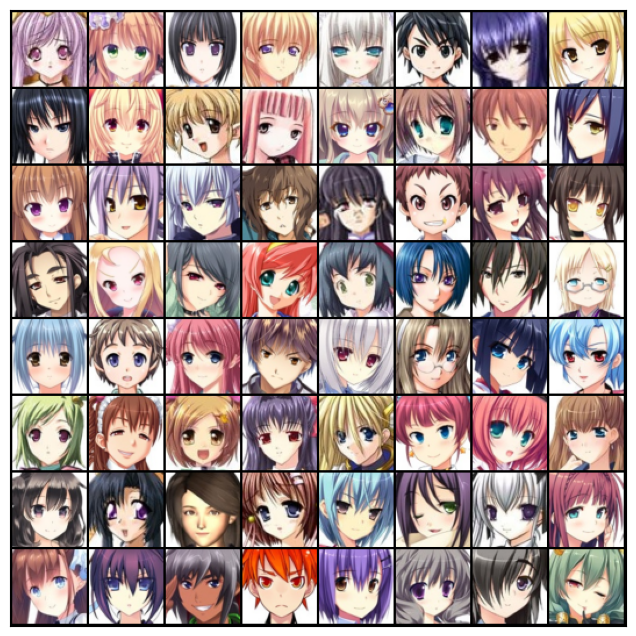

In [11]:
show_batch(train_dl)

Lets create some functions that will help us realted to use the GPU facilities

In [12]:
def get_default_device():
  '''Pick GPU if available, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  '''Wrap a dataloader to move data to a device'''
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)


In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    #in: 3x64x64

    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    #output: 64x 32x 32 (dimensions are reducing cuz stride is 2)

    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    #output: 128x 16x 16

    nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    #output: 256x 8x 8

    nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    #out: 512 x 4 x 4

    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0, bias=False),

    #out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

Lets move discriminator model to GPU

In [17]:
discriminator = to_device(discriminator, device)

# Generator Network

The input to the generator network is typically a vector or random matrix number(referred as latent tensor). Which is used as a seed for generating an image.

The generator will convert a latent tensor of shape (128 x 1 x 1) into an image tensor of shape 3 x 28 x 28.

To acheive this, we will use ConvTranspose2d layer from pytorch. which is performed to as a transposed convolution (also known as deconvolution).

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    #input: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    #output: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1 , bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #Output: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1 , bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    #Output: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1 , bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    #output: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1 , bias = False),
    nn.Tanh()  #Hperbolic tangent function

    #output: 3 x 64 x 64


)

Now that since the output of the Tanh acitvation is also between [-1,1] We have applied the similar transformation to the images in the training dataset. let's generate some outputs using the generator and view them as iamges by transforming and denormalizing the outputs

torch.Size([128, 3, 64, 64])


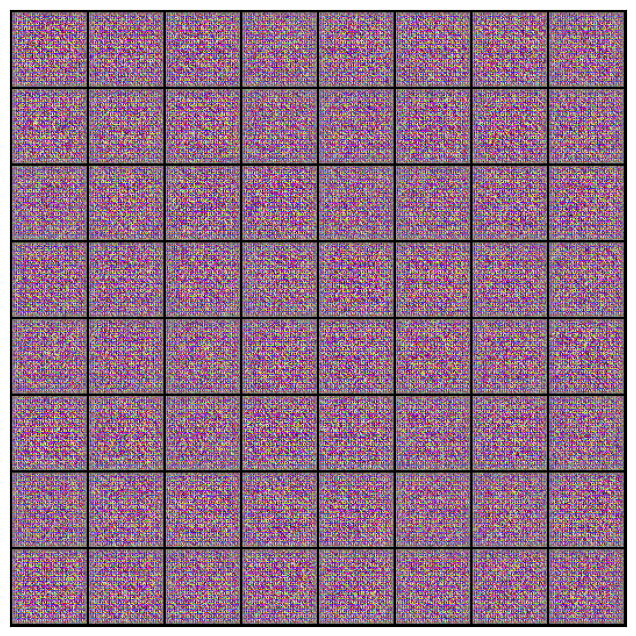

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) #Random latent tensors it will be in the form of 128 x 1 x 1

fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)  #show_images is a function defined above

As the generator is not trained. We are getting random noise

Let's move the generator to the choosen device

In [21]:
generator = to_device(generator, device)

# Descriminator Training

Since the descriminator is a binary classification model. We can use the binary cross entropy loss function to quantify how well it is able to differenciate between real and generated images.

In [22]:
def train_discriminator(real_images, opt_d):
  #Clear descriminator gradients
  opt_d.zero_grad()

  #Pass real images through discriminator

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1, device = device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()


  #Generate fake images

  latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
  fake_images = generator(latent)

  #Pass fake images thorugh discriminator

  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #Update discriminator weights

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score




** Steps involved in training the discriminator**

We expect the discriminator to output 1 if the images is from the MNIST model. and 0 if it is from the generator.

We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then we pass a batch of fake images(generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

it's important to note that we don't chnage the weights of the generator model while training the discriminator(opt_d only affects the discrimnator.parameters())

# Generator Training

Since the output of the generator are images. It's not obvious how we can train the generator. This is where we employ a rather elegent trick, which is to use the discriminator as a part of the loss function. here is how it works:

We generate a batch of images using the generator, pass them into the discriminator.

We calculate the loss by setting the target labels to 1 i.e real. We do this because the generator's objective is to 'Fool' the discriminator.

We use the loss to perform gradient descent i.e change the weights of the generator, so it gets better at generating real-like images to 'fool' the discriminator.

In [23]:
def train_generator(opt_g):
  #Clear generator gradients
  opt_g.zero_grad()

  #Generate fake images

  latent = torch.randn(batch_size, latent_size,1,1, device = device)
  fake_images = generator(latent)

  #Try to fool the discriminator

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device= device)
  loss = F.binary_cross_entropy(preds,targets)


  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

**Let's save a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We will also create a helper function to export the generated images.

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
  print('saving' , fake_fname)
  if show:
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1,2,0))

We will use a fixed set of input vectors to the generators to see how the individual generated images evolve over time as we train them.

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device = device)

saving generated-images-0000.png


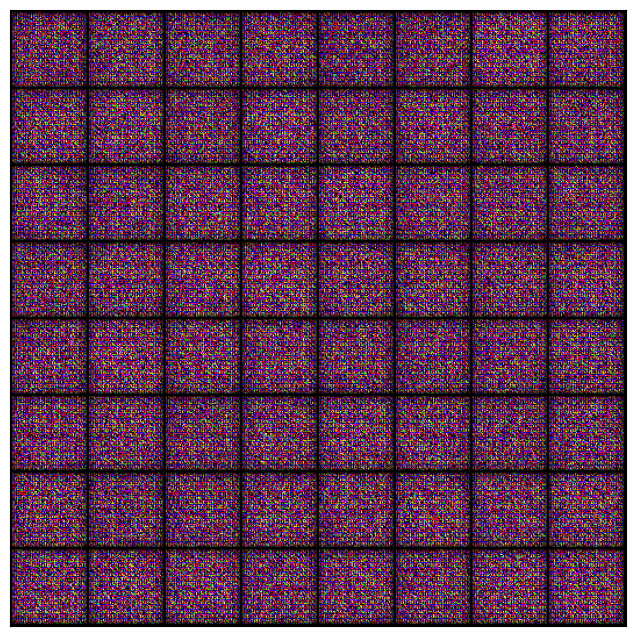

In [28]:
save_samples(0, fixed_latent)

** Let's create a full loop for fit function. Which will generate examples, passed through discriminator and again generate examples.

In [29]:
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  #Losses and Score

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []


  #Create optimization

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))


  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      #Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      #Train generator
      loss_g = train_generator(opt_g)


    #Record losses and scores

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Log losses and scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    #Save generated examples
    save_samples(epoch+start_idx, fixed_latent, show = False)

  return losses_g, losses_d, real_scores, fake_scores


We are now ready to train the model. We can try different learning rates to see if we can maintain the fine balance between the generator training  and the discriminator

In [31]:
lr = 0.0002
epochs = 10


In [32]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 5.2209, loss_d: 0.6994, real_score: 0.8323, fake_score: 0.3462
saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 5.9764, loss_d: 0.2638, real_score: 0.9092, fake_score: 0.1341
saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.4215, loss_d: 0.1979, real_score: 0.8515, fake_score: 0.0023
saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 6.0572, loss_d: 0.3202, real_score: 0.7690, fake_score: 0.0071
saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 9.3495, loss_d: 0.6483, real_score: 0.9449, fake_score: 0.3826
saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 6.6854, loss_d: 0.1652, real_score: 0.9724, fake_score: 0.1211
saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.4622, loss_d: 0.0572, real_score: 0.9792, fake_score: 0.0344
saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.5857, loss_d: 0.0776, real_score: 0.9605, fake_score: 0.0317
saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.2867, loss_d: 0.0292, real_score: 0.9860, fake_score: 0.0127
saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 18.9813, loss_d: 0.7317, real_score: 0.9995, fake_score: 0.3358
saving generated-images-0010.png


In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
#Save the model check points

torch.save(generator.state_dict(), 'G_anime_faces.pth')
torch.save(discriminator.state_dict(), 'D_anime_faces.pth')

In [37]:
import cv2
import os

vid_fname = 'GAN-training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()